In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import time
from itertools import product
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [3]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

### 광어 

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [28]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# # 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 26261, number of used features: 32
[LightGBM] [Info] Start training from score 35918.308899
1.0679495334625244

** Model Performance **
Best RMSE: 1139.4691

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 8
min_child_samples: 7
n_estimators: 260
n_jobs: -1
num_leaves: 9
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 306.1630
MSE: 419884.3656
RMSE: 647.9848
R2: 0.9828
RMSLE: 0.0178
MAPE: 0.8457
Training_Time: 1.0679

** Market-wise Metrics **
m_가락시장: RMSE = 541.2379, R2 = 0.9873, MAE = 286.4411, MAPE = 0.7586
m_강서농수산물시장: RMSE = 879.8919, R2 = 0.9842, MAE = 532.4880, MAPE = 1.3241
m_구리농수산물시장: RMSE = 994.2777, R2 = 0.8485, MAE = 406.7952, MAPE = 1.0659

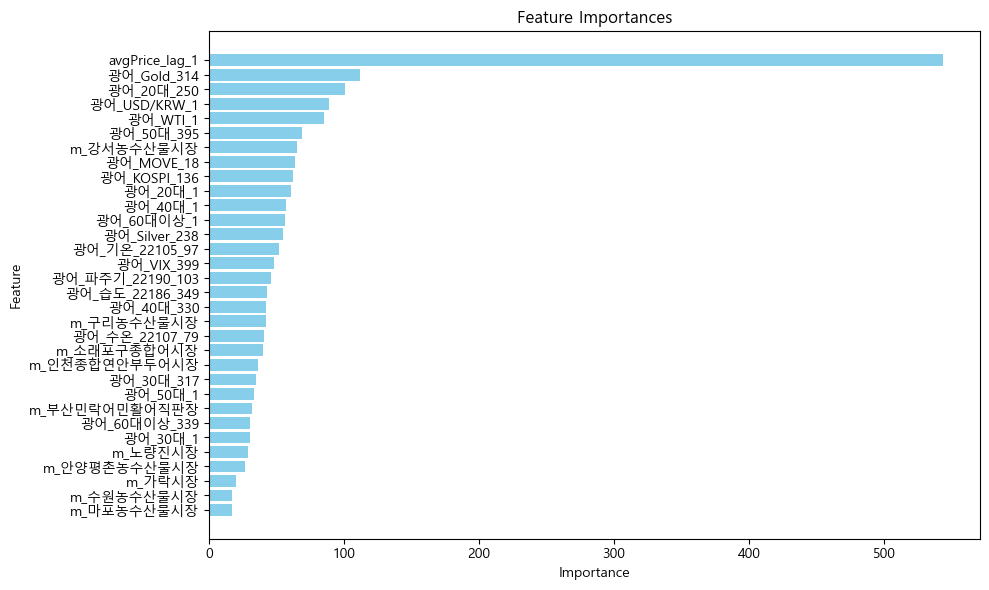

LGBMRegressor(colsample_bytree=0.9, max_depth=8, min_child_samples=7,
              n_estimators=260, n_jobs=-1, num_leaves=9, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.


In [33]:
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = [
#      '광어_Silver_238' ,
#        '광어_MOVE_18' ,
#        '광어_VIX_399' ,
#    # '광어_수온_22107_79' ,
#         #'광어_40대_330' ,
#        #  '광어_60대이상_1' ,
# #   '광어_파주기_22190_103' ,
#       #'광어_60대이상_339' ,
#        #   '광어_50대_1' ,
#       #  '광어_30대_317' ,
#      'm_인천종합연안부두어시장' ,
#        'm_소래포구종합어시장' ,
#            'm_노량진시장' ,
#      'm_부산민락어민활어직판장' ,
#        'm_안양평촌농수산물시장' ,
#          'm_수원농수산물시장' ,
        #       'm_가락시장' ,
        #  'm_마포농수산물시장' ,
     ]


model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_광어)

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_광어.joblib')  

print("\n학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.")

### 농어

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [ 100],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [64]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [100],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 25023, number of used features: 31
[LightGBM] [Info] Start training from score 36142.972066
0.7528946399688721

** Model Performance **
Best RMSE: 1296.2797

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 6
min_child_samples: 6
n_estimators: 100
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 413.2862
MSE: 727533.4130
RMSE: 852.9557
R2: 0.9702
RMSLE: 0.0230
MAPE: 1.1209
Training_Time: 0.7529

** Market-wise Metrics **
m_가락시장: RMSE = 750.7599, R2 = 0.9775, MAE = 377.9599, MAPE = 1.0587
m_강서농수산물시장: RMSE = 989.4383, R2 = 0.9704, MAE = 610.7351, MAPE = 1.6868
m_구리농수산물시장: RMSE = 1042.7442, R2 = 0.9484, MAE = 474.0074, MAPE = 1.3

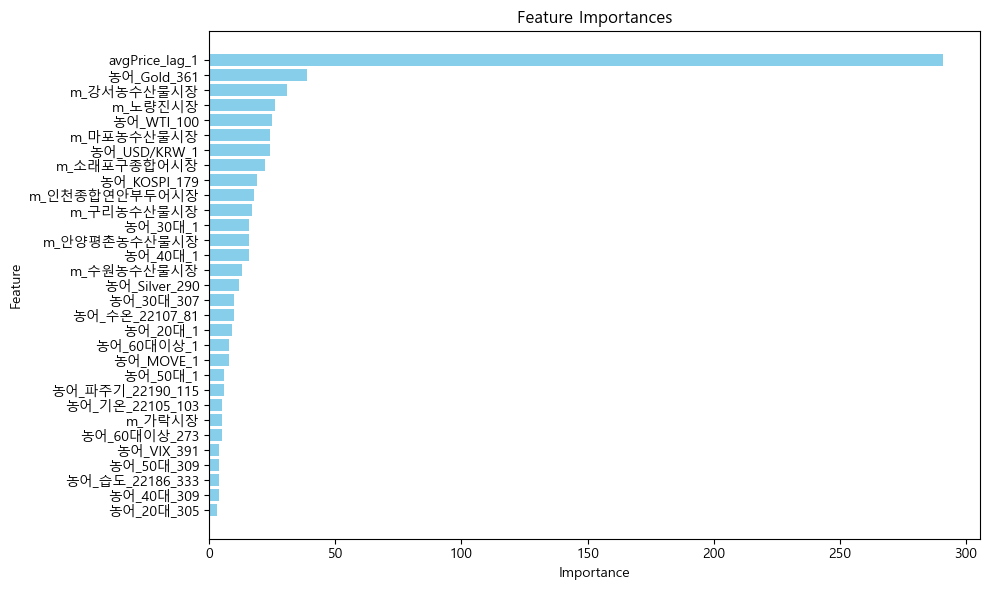

LGBMRegressor(colsample_bytree=0.9, max_depth=6, min_child_samples=6, n_jobs=-1,
              num_leaves=8, random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.


In [65]:
data = pd.read_csv('../../../data/features/final_oneHot/농어_price_features_notnull.csv')


exclude_features = ['m_부산민락어민활어직판장']
model_농어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_농어)

# 학습된 모델 저장
joblib.dump(model_농어, 'lgbm_농어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.")

### 대게

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [66]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5109
[LightGBM] [Info] Number of data points in the train set: 21281, number of used features: 25
[LightGBM] [Info] Start training from score 56154.152061
0.6484372615814209

** Model Performance **
Best RMSE: 2334.2084

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 7
min_child_samples: 6
n_estimators: 90
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 928.4731
MSE: 3747653.1416
RMSE: 1935.8856
R2: 0.9773
RMSLE: 0.0358
MAPE: 1.7281
Training_Time: 0.6484

** Market-wise Metrics **
m_가락시장: RMSE = 2178.0619, R2 = 0.9677, MAE = 1014.3646, MAPE = 1.6494
m_강서농수산물시장: RMSE = 1492.4203, R2 = 0.9843, MAE = 750.7302, MAPE = 1.4823
m_구리농수산물시장: RMSE = 2453.6626, R2 = 0.9558, MAE = 1303.3509, MAPE 

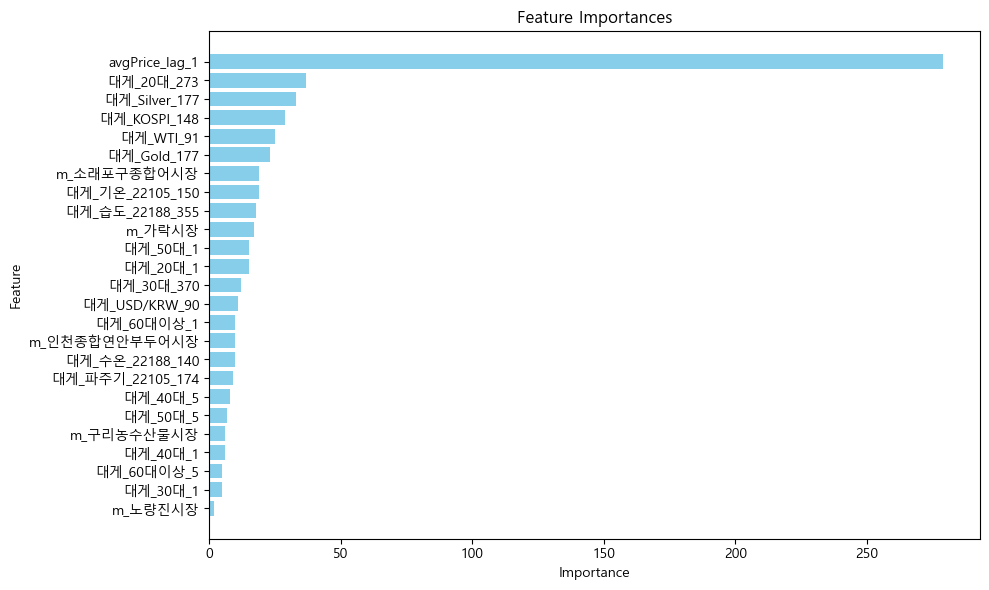

LGBMRegressor(colsample_bytree=0.9, max_depth=7, min_child_samples=6,
              n_estimators=90, n_jobs=-1, num_leaves=8, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.


In [67]:
data = pd.read_csv('../../../data/features/final_oneHot/대게_price_features_notnull.csv')


exclude_features = [
     'm_강서농수산물시장'  ,
   'm_안양평촌농수산물시장'  ,
     'm_수원농수산물시장'  ,
  'm_부산민락어민활어직판장'  ,
     'm_마포농수산물시장'  ,
]
model_대게 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_대게)

# 학습된 모델 저장
joblib.dump(model_대게, 'lgbm_대게.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_대게.joblib'로 저장되었습니다.")

### 방어

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [45],
		'max_depth': [2],
		'learning_rate': [0.11],
		'num_leaves': [4],
		'min_child_samples': [7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}


In [68]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [45],
		'max_depth': [2],
		'learning_rate': [0.11],
		'num_leaves': [4],
		'min_child_samples': [7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 9526, number of used features: 8
[LightGBM] [Info] Start training from score 36486.538946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.21117925643920898

** Model Performance **
Best RMSE: 917.4354

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.11
max_depth: 2
min_child_samples: 7
n_estimators: 45
n_jobs: -1
num_leaves: 4
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 278.5126
MSE: 898751.2851
RMSE: 948.0249
R2: 0.9844
RMSLE: 0.0258
MAPE: 0.7666
Training_Time: 0.2112

** Market-wi

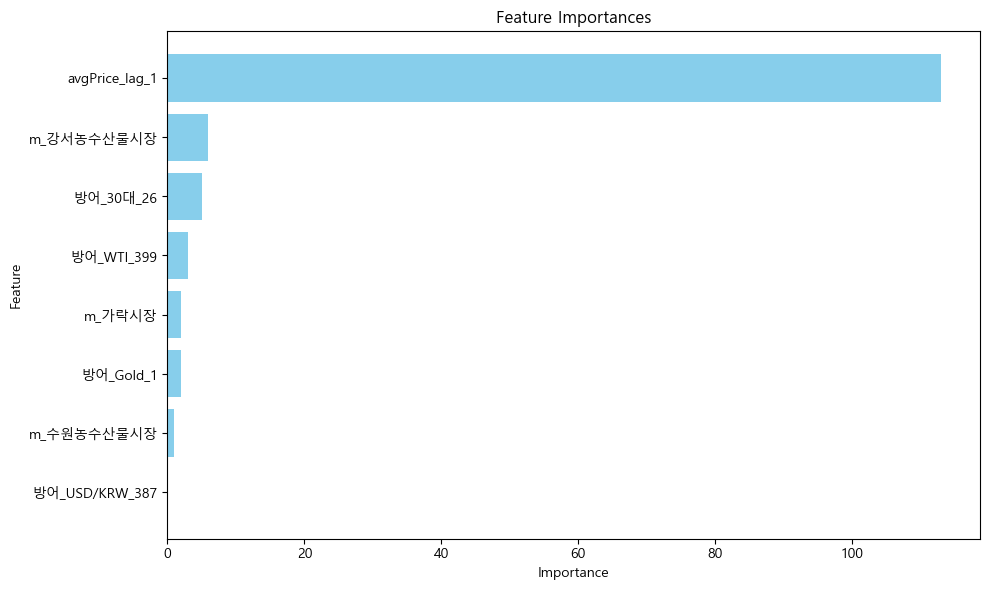

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.11, max_depth=2,
              min_child_samples=7, n_estimators=45, n_jobs=-1, num_leaves=4,
              random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.


In [69]:
data = pd.read_csv('../../../data/features/final_oneHot/방어_price_features_notnull.csv')

exclude_features = [
           'm_노량진시장',
   '방어_습도_22190_158',
   '방어_기온_22190_114',
        'm_구리농수산물시장',
        '방어_VIX_133',
       '방어_Silver_1',
       '방어_MOVE_381',
      '방어_KOSPI_282',
       '방어_60대이상_26',
      'm_안양평촌농수산물시장',
        '방어_60대이상_1',
        '방어_50대_256',
          '방어_50대_1',
        'm_마포농수산물시장',
          '방어_40대_1',
     'm_부산민락어민활어직판장',
         '방어_20대_22',
          '방어_20대_1',
       'm_소래포구종합어시장',
  '방어_파주기_22105_191' ,
    'm_인천종합연안부두어시장',
         '방어_30대_1',
       '방어_40대_256',
  '방어_수온_22107_118',
 # '방어_USD/KRW_387'
]
model_방어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_방어)

# 학습된 모델 저장
joblib.dump(model_방어, 'lgbm_방어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_방어.joblib'로 저장되었습니다.")

### 연어

#### ~~노르웨이 포함~~

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [246]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5793
[LightGBM] [Info] Number of data points in the train set: 23741, number of used features: 32
[LightGBM] [Info] Start training from score 4769.059854
0.5596559047698975

** Model Performance **
Best RMSE: 376.3076

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.09
max_depth: 7
min_child_samples: 6
n_estimators: 60
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 88.2359
MSE: 43234.0510
RMSE: 207.9280
R2: 0.9748
RMSLE: 0.0365
MAPE: 1.7328
Training_Time: 0.5597

** Market-wise Metrics **
m_가락시장: RMSE = 304.0787, R2 = 0.9277, MAE = 151.9512, MAPE = 2.5286
m_강서농수산물시장: RMSE = 200.1858, R2 = 0.9729, MAE = 129.3809, MAPE = 2.7772
m_구리농수산물시장: RMSE = 125.0779, R2 = 0.9870, MAE = 45.3619, MAPE = 1.1484
m_

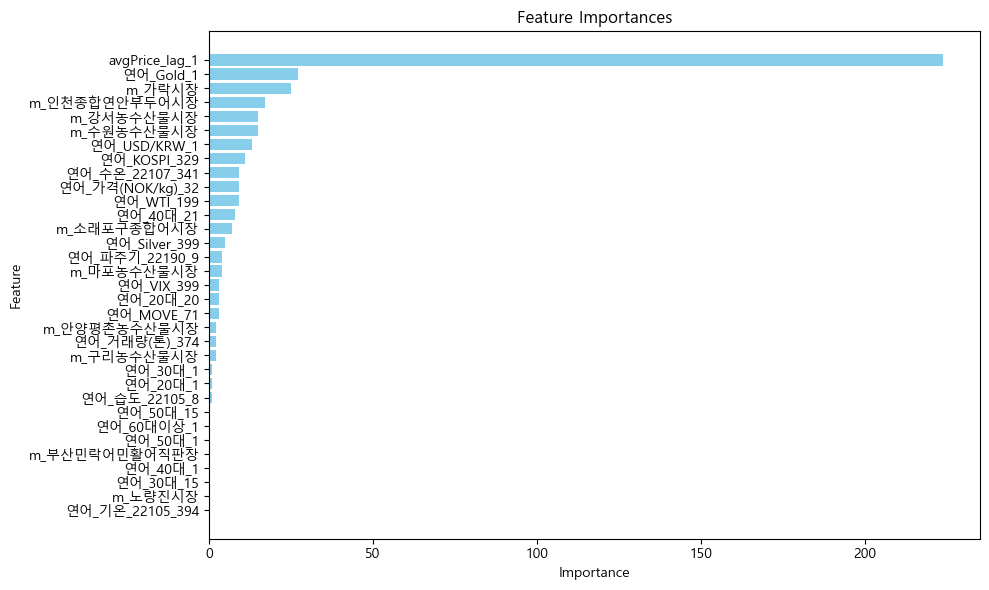

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.09, max_depth=7,
              min_child_samples=6, n_estimators=60, n_jobs=-1, num_leaves=8,
              random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.


In [84]:
data = pd.read_csv('../../../data/features/final_oneHot/연어_price_features_notnull_노르웨이포함.csv')


exclude_features = [
     '연어_60대이상_397',
 #       '연어_50대_15',
    #      '연어_40대_1',
    #     '연어_30대_15',
    #      '연어_20대_1',
    # 'm_부산민락어민활어직판장',
    #       'm_노량진시장',
    #      '연어_50대_1'    
    
]
model_연어= train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_연어)

# 학습된 모델 저장
joblib.dump(model_연어, 'lgbm_연어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.")

#### 노르웨이 제외

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [7],
		'learning_rate': [0.09],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [70]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [60],
		'max_depth': [7],
		'learning_rate': [0.09],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 23741, number of used features: 22
[LightGBM] [Info] Start training from score 4769.059854
0.4872713088989258

** Model Performance **
Best RMSE: 373.0585

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.09
max_depth: 7
min_child_samples: 6
n_estimators: 60
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 87.8921
MSE: 43009.5563
RMSE: 207.3875
R2: 0.9749
RMSLE: 0.0364
MAPE: 1.7264
Training_Time: 0.4873

** Market-wise Metrics **
m_가락시장: RMSE = 302.5026, R2 = 0.9285, MAE = 152.2768, MAPE = 2.5351
m_강서농수산물시장: RMSE = 204.6340, R2 = 0.9716, MAE = 130.7504, MAPE = 2.7999
m_구리농수산물시장: RMSE = 123.8876, R2 = 0.9873, MAE = 45.4574, MAPE = 1.1447
m_

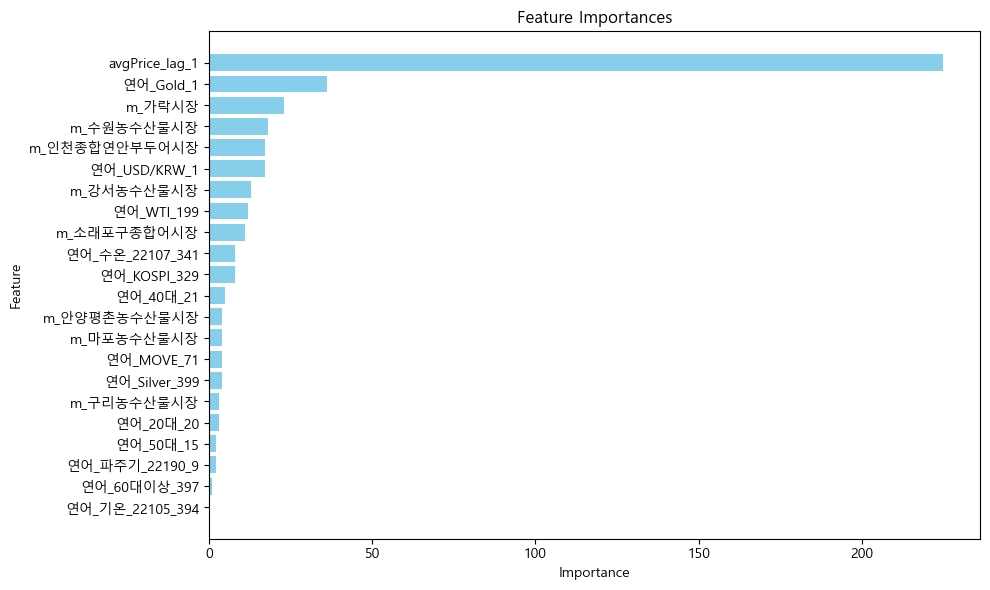

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.09, max_depth=7,
              min_child_samples=6, n_estimators=60, n_jobs=-1, num_leaves=8,
              random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.


In [78]:
data = pd.read_csv('../../../data/features/final_oneHot/연어_price_features_notnull_노르웨이제외.csv')
exclude_features = [
#      '광어_Silver_238' ,
    ]

exclude_features = [
       '연어_60대이상_1',
         '연어_50대_1',
       '연어_VIX_399',
          'm_노량진시장',
    '연어_습도_22105_8',
    'm_부산민락어민활어직판장',
    '연어_30대_1',
    '연어_40대_1',
    '연어_20대_1',
    '연어_30대_15',

]
model_연어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_연어)

# 학습된 모델 저장
joblib.dump(model_연어, 'lgbm_연어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_연어.joblib'로 저장되었습니다.")

### 우럭

    #250128 기준 확정 
    lgbm_params = {
        
        'n_estimators': [ 105 ],
        'max_depth': [3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [8],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
    }

In [57]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250128 기준 확정 
	lgbm_params = {
        'n_estimators': [ 105 ],
        'max_depth': [3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [8],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 5325, number of used features: 26
[LightGBM] [Info] Start training from score 33547.233803
0.3534524440765381

** Model Performance **
Best RMSE: 850.4993

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 3
min_child_samples: 8
n_estimators: 105
n_jobs: -1
num_leaves: 4
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 481.2260
MSE: 894180.9756
RMSE: 945.6114
R2: 0.9447
RMSLE: 0.0289
MAPE: 1.4591
Training_Time: 0.3535

** Market-wise Metrics **
m_가락시장: RMSE = 1089.2571, R2 = 0.4728, MAE = 530.6505, MAPE = 1.3903
m_강서농수산물시장: RMSE = 1059.6970, R2 = 0.1967, MAE = 830.0663, MAPE = 2.0018
m_구리농수산물시장: RMSE = 1055.7017, R2 = 0.1656, MAE = 325.7800, MAPE = 0.9

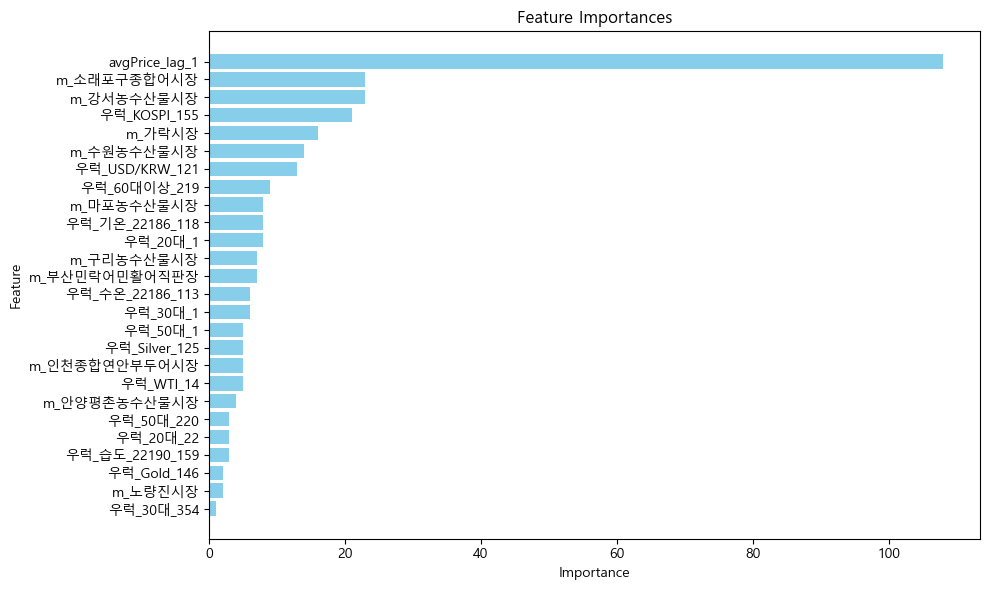

LGBMRegressor(colsample_bytree=0.9, max_depth=3, min_child_samples=8,
              n_estimators=105, n_jobs=-1, num_leaves=4, random_state=1030,
              subsample=0.9)
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 8, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 105, 'n_jobs': -1, 'num_leaves': 4, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0}

학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.


In [63]:
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
exclude_features = [
'우럭_40대_1',
       '우럭_40대_354',
        '우럭_60대이상_1',   
  '우럭_파주기_22189_172', 
  '우럭_VIX_38'
    ]


model_우럭 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features)

print(model_우럭)
print(model_우럭.get_params())

# 학습된 모델 저장
joblib.dump(model_우럭, 'lgbm_우럭.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_우럭.joblib'로 저장되었습니다.")

### 참돔

    #250128 기준 확정 
    lgbm_params = {
        'n_estimators': [75],
        'max_depth': [ 3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [6],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
    }

In [54]:
def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [90],
		'max_depth': [7],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=10, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	# plt.figure(figsize=(15, 7))
	# plt.plot(data['date'], y, label='Actual', color='blue')
	# plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	# plt.title('Actual vs Predicted Price')
	# plt.xlabel('Date')
	# plt.ylabel('Price')
	# plt.legend()
	# plt.grid(True)
	# plt.xticks(rotation=45)
	# plt.tight_layout()
	# plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# # 그래프 생성
			# plt.figure(figsize=(15, 7))
			# plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			# plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			# plt.title(f'Actual vs Predicted Price ({col})')
			# plt.xlabel('Date')
			# plt.ylabel('Price')
			# plt.legend()
			# plt.grid(True)
			# plt.xticks(rotation=45)								
			# plt.tight_layout()
			# plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 23088, number of used features: 28
[LightGBM] [Info] Start training from score 37020.801715
0.6532347202301025

** Model Performance **
Best RMSE: 834.1810

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 7
min_child_samples: 6
n_estimators: 90
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9

Final Metrics:
MAE: 258.9995
MSE: 350365.9644
RMSE: 591.9172
R2: 0.9724
RMSLE: 0.0156
MAPE: 0.6859
Training_Time: 0.6532

** Market-wise Metrics **
m_가락시장: RMSE = 553.2843, R2 = 0.9639, MAE = 295.5185, MAPE = 0.7769
m_강서농수산물시장: RMSE = 925.0789, R2 = 0.9578, MAE = 594.8743, MAPE = 1.4750
m_구리농수산물시장: RMSE = 212.2001, R2 = 0.9915, MAE = 69.1500, MAPE = 0.1935


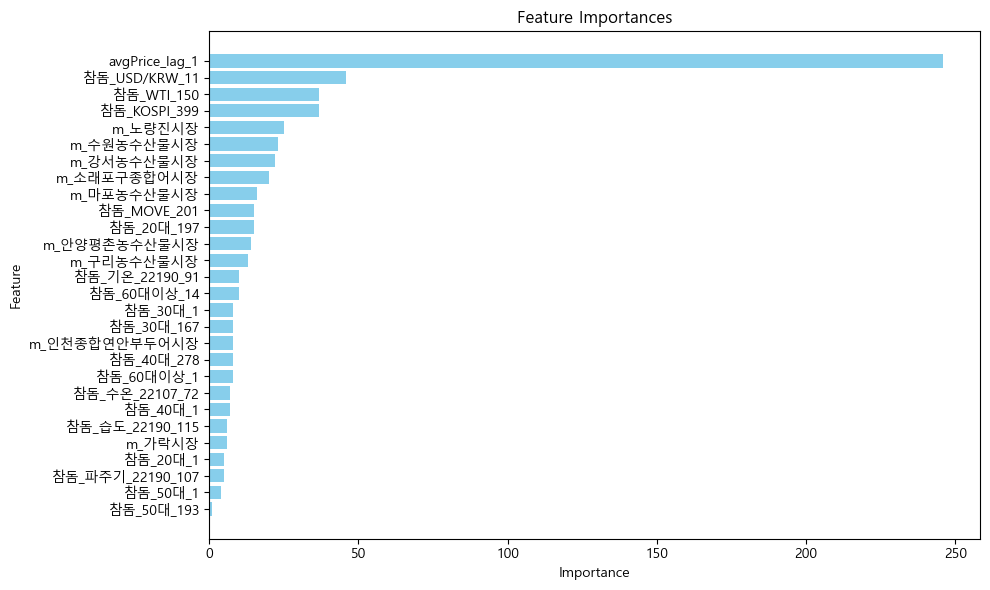

LGBMRegressor(colsample_bytree=0.9, max_depth=7, min_child_samples=6,
              n_estimators=90, n_jobs=-1, num_leaves=8, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.


In [56]:
data = pd.read_csv('../../../data/features/final_oneHot/참돔_price_features_notnull.csv')


exclude_features = ['m_부산민락어민활어직판장']
model_참돔 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_참돔)

# 학습된 모델 저장
joblib.dump(model_참돔, 'lgbm_참돔.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_참돔.joblib'로 저장되었습니다.")

### 기타

#### 가격 예측 

In [ ]:
# 저장된 모델 로드
loaded_model = joblib.load('xgb_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")

모델이 성공적으로 로드되었습니다.


In [ ]:
# 저장된 모델 및 피처 이름 로드
loaded_model = joblib.load('xgb_광어.joblib')
feature_names = joblib.load('feature_names.pkl')

# 예측 데이터 준비
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv') 
X = data[feature_names]  # 학습 시 사용된 피처만 선택

# 결과 저장용 리스트
market_predictions = []

# 시장별 예측
markets = [
	"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
	"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장",
	"m_수원농수산물시장", "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
]

for market in markets:
	# 시장별 데이터 필터링
	market_data = data[data[market] == 1]

	if not market_data.empty:  # 데이터가 존재할 경우에만 실행
		X = market_data[feature_names]  # 학습 시 사용된 피처만 선택
		y_pred = loaded_model.predict(X)  # 시장별 예측

		# 다음날 날짜 생성
		last_date = pd.to_datetime(market_data['date'].iloc[-1])  # 마지막 날짜
		next_date = last_date + pd.Timedelta(days=1)

		# 결과 저장
		market_predictions.append({
			'Market': market,
			'Next_Date': next_date.strftime('%Y-%m-%d'),
			'Predicted_Price': y_pred[-1]  # 가장 마지막 예측 값 (다음날 예측)
		})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(market_predictions)

# 결과 출력
print("시장별 내일 가격 예측:")
print(result_df)

# # 결과 저장
# result_df.to_csv('market_predictions.csv', index=False)
# print("시장별 예측 결과가 'market_predictions.csv'에 저장되었습니다.")


시장별 내일 가격 예측:
          Market   Next_Date  Predicted_Price
0         m_가락시장  2025-01-01     44670.269531
1     m_강서농수산물시장  2025-01-01     47503.644531
2     m_구리농수산물시장  2025-01-01     40043.246094
3        m_노량진시장  2025-01-01     39562.347656
4     m_마포농수산물시장  2025-01-01     44670.269531
5  m_부산민락어민활어직판장  2025-01-01     40129.937500
6    m_소래포구종합어시장  2025-01-01     41195.082031
7     m_수원농수산물시장  2025-01-01     42062.718750
8   m_안양평촌농수산물시장  2025-01-01     44670.269531
9  m_인천종합연안부두어시장  2025-01-01     38734.714844


def train_evaluate_lgbm_walk_forward(data, target_col='avgPrice', exclude_features=None, train_size=6000, test_size=300, step=5):
    """
    LightGBM 모델의 Walk-Forward (Blocking) 방식 평가 및 결과 시각화

    Args:
        data (pd.DataFrame): 학습 데이터
        target_col (str): 타겟 변수 이름
        exclude_features (list): 제외할 피처 리스트
        train_size (int): 고정된 훈련 데이터 크기
        test_size (int): 검증 데이터 크기
        step (int): Walk-Forward 분할 간격
    """
    # 데이터 전처리
    data['date'] = pd.to_datetime(data['date'])
    X = data.drop(['date', 'item', target_col], axis=1)
    y = data[target_col]

    # 특정 피처 제외
    if exclude_features:
        X = X.drop(columns=exclude_features)

    # 하이퍼파라미터 설정
    #250128 기준 확정 
    lgbm_params = {
        'n_estimators': [75],
        'max_depth': [ 3],
        'learning_rate': [0.1],
        'num_leaves': [4],
        'min_child_samples': [6],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'random_state': [1030],
        'n_jobs': [-1]
    }
    
    step = 5
    # Walk-Forward 방식의 데이터 분할 설정
    n_splits = (len(X) - train_size) // (test_size * step)
    splits = []
    for i in range(n_splits):
        train_start = i * test_size * step
        train_end = train_start + train_size
        test_start = train_end
        test_end = test_start + test_size
        splits.append((slice(train_start, train_end), slice(test_start, test_end)))

    print(f"Number of splits: {len(splits)}")

    lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)

    # Walk-Forward 평가 결과 저장
    all_dates = []
    all_actuals = []
    all_predictions = []

    # Walk-Forward 평가
    for split_idx, (train_idx, test_idx) in enumerate(splits):
        # 훈련 및 검증 데이터 설정
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(
            lgbm, lgbm_params,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        # 모델 학습
        grid_search.fit(X_train, y_train)

        # 최적 모델로 검증 데이터 예측
        y_pred = grid_search.predict(X_test)

        # 결과 저장
        all_dates.extend(data['date'].iloc[test_idx])
        all_actuals.extend(y_test)
        all_predictions.extend(y_pred)

        print(f"Split {split_idx + 1}: RMSE={np.sqrt(mean_squared_error(y_test, y_pred)):.4f}, "
              f"R²={r2_score(y_test, y_pred):.4f}")

    # 전체 데이터 병합
    results = pd.DataFrame({
        'date': all_dates,
        'actual': all_actuals,
        'predicted': all_predictions
    })

    # # 특정 항목별 그래프 생성
    # columns_to_filter = [
    #     "m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
    #     "m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
    #     "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
    # ]

    # metrics_by_market = {}  # 시장별 성능 저장

    # for col in columns_to_filter:
    #     filtered_data = data[data[col] == 1]
    #     filtered_y = y[data[col] == 1]
    #     filtered_y_pred = y_pred[data[col] == 1]

    #     if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
    #         # RMSE와 R2 계산
    #         rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
    #         r2 = r2_score(filtered_y, filtered_y_pred)
    #         mae = mean_absolute_error(filtered_y, filtered_y_pred)
    #         mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
            
    #         metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

    #         # 그래프 생성
    #         plt.figure(figsize=(15, 7))
    #         plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
    #         plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
    #         plt.title(f'Actual vs Predicted Price ({col})')
    #         plt.xlabel('Date')
    #         plt.ylabel('Price')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.xticks(rotation=45)								
    #         plt.tight_layout()
    #         plt.show()


    # # 최종 메트릭 계산 및 출력
    # metrics = calculate_metrics(y, y_pred)
    # print("\nFinal Metrics:")
    # for k, v in metrics.items():
    #     print(f"{k}: {v:.4f}")


    # # 시장별 성능 출력
    # print("\n** Market-wise Metrics **")
    # for market, metrics in metrics_by_market.items():
    #     print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

        
    # 중요도 계산 및 시각화
    feature_importances = grid_search.best_estimator_.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # # 전체 예측 결과 시각화
    # plt.figure(figsize=(15, 7))
    # plt.plot(results['date'], results['actual'], label='Actual', color='blue')
    # plt.plot(results['date'], results['predicted'], label='Predicted', color='red', linestyle='--')
    # plt.title('Actual vs Predicted Price (All Splits)')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.grid(True)
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    return grid_search.best_estimator_
